In [1]:
import sys
assert sys.version_info >= (3, 5)


import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os


np.random.seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear Regression

Un modèle linéaire fait une prédiction en calculant simplement une somme pondérée des caractéristiques d'entrée, plus une constante appelée le terme de biais (également appelé terme d'interception), comme le montre l'Équation 4-1 :

$ \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n $

Dans cette équation :
- $ \hat{y} $ est la valeur prédite.
- $ n $ est le nombre de caractéristiques.
- $ x_i $ est la valeur de la i-ème caractéristique.
- $ \theta_j $ est le j-ème paramètre du modèle, incluant le terme de biais $ \theta_0 $ et les poids des caractéristiques $ \theta_1, \theta_2, \cdots, \theta_n $.

Cette formulation peut être écrite de manière beaucoup plus concise en utilisant une forme vectorisée, comme montré dans l'Équation 4-2 :

$ y = h_\theta(x) = \theta \cdot x $

Dans cette équation :
- $ h_\theta $ est la fonction hypothèse, utilisant les paramètres du modèle $ \theta $.
- $ \theta $ est le vecteur de paramètres du modèle, contenant le terme de biais $ \theta_0 $ et les poids des caractéristiques de $ \theta_1 $ à $ \theta_n $.
- $ x $ est le vecteur des caractéristiques de l'instance, contenant de $ x_0 $ à $ x_n $, avec $ x_0 $ toujours égal à 1.
- $ \theta \cdot x $ est le produit scalaire des vecteurs $ \theta $ et $ x $, qui est égal à $ \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n

L'équation normale est une solution en forme fermée pour trouver la valeur de θ qui minimise l'erreur quadratique moyenne (MSE). Voici comment elle est formulée :

$ \theta = (X^\top X)^{-1} X^\top y $

Dans cette équation :
- $  \hat{\theta}$ est la valeur qui minimise la fonction de coût.
- $ y $ est le vecteur des valeurs cibles contenant $y(1)$ jusqu'à $y(m)$.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


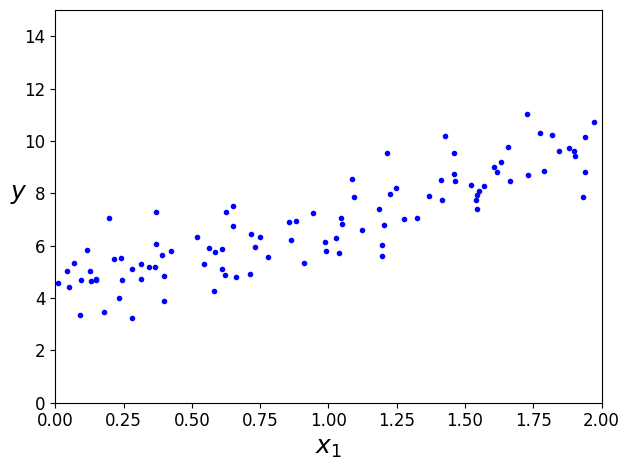

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

Nous aurions espéré obtenir $ \theta_0 = 4 $ et $ \theta_1 = 3 $ au lieu de $ \theta_0 = 4.35 $ et $ \theta_1 = 2.77 $. C'est assez proche, mais le bruit a rendu impossible la récupération exacte des paramètres de la fonction originale. Plus le jeu de données est petit et bruyant, plus cela devient difficile.

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure linear_model_predictions_plot


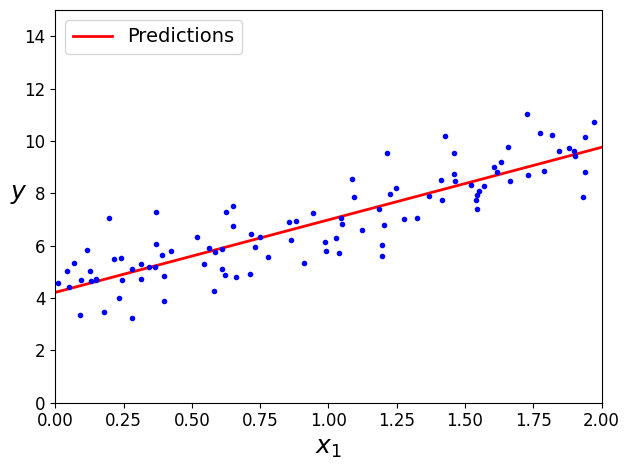

In [7]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

Notez que Scikit-Learn sépare le terme de biais (intercept_) des poids des caractéristiques (coef_).

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

La complexité computationnelle de l'équation normale implique le calcul de l'inverse de $ X^\top X $, qui est une matrice de taille $ (n + 1) \times (n + 1) $ (où $ n $ est le nombre de caractéristiques). La complexité de l'inversion d'une telle matrice est typiquement d'environ $ O(n^{2.4}) $ à $ O(n^3) $, en fonction de l'implémentation. Autrement dit, si vous doublez le nombre de caractéristiques, le temps de calcul est multiplié approximativement par $ 2^{2.4} = 5.3 $ à $ 2^3 = 8 $.

De plus, une fois que vous avez entraîné votre modèle de régression linéaire (en utilisant l'équation normale ou tout autre algorithme), les prédictions sont très rapides : la complexité computationnelle est linéaire par rapport au nombre d'instances sur lesquelles vous souhaitez faire des prédictions et au nombre de caractéristiques. En d'autres termes, faire des prédictions sur deux fois plus d'instances (ou deux fois plus de caractéristiques) prendra approximativement deux fois plus de temps.

Nous allons maintenant examiner une manière très différente d'entraîner un modèle de régression linéaire, mieux adaptée aux cas où il y a un grand nombre de caractéristiques ou trop d'instances de formation pour tenir en mémoire.

# La descente de gradient

La descente de gradient est un algorithme d'optimisation générique capable de trouver des solutions optimales à une large gamme de problèmes. L'idée générale de la descente de gradient est d'ajuster les paramètres de manière itérative afin de minimiser une fonction de coût.

Supposons que vous êtes perdu dans les montagnes par un épais brouillard, et que vous pouvez seulement sentir la pente du sol sous vos pieds. Une bonne stratégie pour atteindre rapidement le fond de la vallée consiste à descendre dans la direction de la pente la plus raide. C'est exactement ce que fait la descente de gradient : elle mesure le gradient local de la fonction d'erreur par rapport au vecteur de paramètres $ \theta $, et elle se dirige dans la direction du gradient descendant. Une fois que le gradient est zéro, vous avez atteint un minimum !

En pratique, vous commencez par remplir $ \theta $ avec des valeurs aléatoires (ceci est appelé initialisation aléatoire). Ensuite, vous l'améliorez progressivement, en prenant un petit pas à la fois, chaque pas tentant de diminuer la fonction de coût.

Pour mettre en œuvre la descente de gradient, il est nécessaire de calculer le gradient de la fonction de coût par rapport à chaque paramètre du modèle $ \theta_j $. En d'autres termes, vous devez calculer combien la fonction de coût changerait si vous modifiez légèrement $ \theta_j $.

Ceci est appelé une dérivée partielle. Cela revient à se demander, « Quelle est la pente de la montagne sous mes pieds si je fais face à l'est ? » puis à poser la même question en faisant face au nord (et ainsi de suite pour toutes les autres dimensions, si vous pouvez imaginer un univers avec plus de trois dimensions).

L'Équation 4-5 calcule la dérivée partielle de l'erreur quadratique moyenne (MSE) par rapport au paramètre $ \theta_j $, notée $ \frac{\partial \text{MSE}(\theta)}{\partial \theta_j} $.

$ \frac{\partial \text{MSE}(\theta)}{\partial \theta_j} = \frac{2}{m} \sum_{i=1}^m (\theta^\top x_i - y_i) x_{ji} $

Au lieu de calculer ces dérivées partielles individuellement, vous pouvez utiliser l'Équation 4-6 pour les calculer toutes en une seule fois. Le vecteur de gradient, noté \( \nabla_\theta \text{MSE}$theta) $, contient toutes les dérivées partielles de la fonction de coût (une pour chaque paramètre du modèle).

$\nabla_\theta \text{MSE}(\theta) = \begin{bmatrix} \frac{\partial \text{MSE}(\theta)}{\partial \theta_0} \\ \frac{\partial \text{MSE}(\theta)}{\partial \theta_1} \\ \vdots \\ \frac{\partial \text{MSE}(\theta)}{\partial \theta_n} \end{bmatrix} = \frac{2}{m} X^\top (X \theta - y) $

Cette formule permet de calculer efficacement le gradient pour tous les paramètres, facilitant ainsi l'ajustement des paramètres de manière itérative pour minimiser la fonction de coût.

In [10]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):

    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)

    theta = theta - eta * gradients

In [11]:
theta

array([[4.21509616],
       [2.77011339]])

In [12]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

Effectivement, c'est exactement ce que l'équation normale a trouvé ! La descente de gradient a fonctionné parfaitement. Mais que se passerait-il si vous aviez utilisé un taux d'apprentissage différent (eta) ?

In [13]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 30:

            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)

        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)

    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


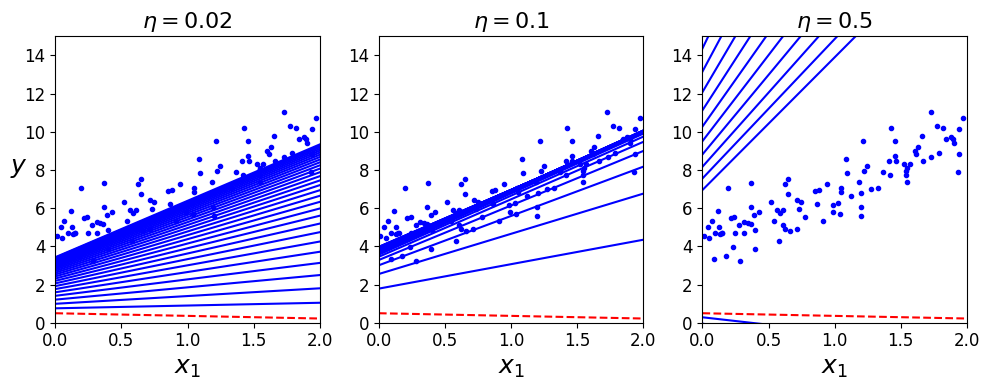

In [14]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

Sur la gauche, le taux d'apprentissage est trop faible : l'algorithme atteindra finalement la solution, mais cela prendra beaucoup de temps. Au milieu, le taux d'apprentissage semble assez bon : en seulement quelques époques, il a déjà convergé vers la solution. À droite, le taux d'apprentissage est trop élevé : l'algorithme diverge, sautant partout et s'éloignant de plus en plus de la solution à chaque étape.

Pour trouver un bon taux d'apprentissage, vous pouvez utiliser la recherche en grille (voir le Chapitre 2). Cependant, vous voudrez peut-être limiter le nombre d'époques afin que la recherche en grille puisse éliminer les modèles qui prennent trop de temps à converger.

Vous vous demandez peut-être comment définir le nombre d'époques. Si ce nombre est trop bas, vous serez encore loin de la solution optimale lorsque l'algorithme s'arrêtera ; mais s'il est trop élevé, vous perdrez du temps tandis que les paramètres du modèle ne changent plus. Une solution simple est de définir un très grand nombre d'époques, mais d'interrompre l'algorithme lorsque le vecteur de gradient devient minuscule — c'est-à-dire lorsque sa norme devient inférieure à un très petit nombre ϵ (appelé la tolérance) — car cela se produit lorsque la descente de gradient a (presque) atteint le minimum.

## Stochastic Gradient Descent

Le principal problème de la descente de gradient en batch est qu'elle utilise l'ensemble de l'entraînement pour calculer les gradients à chaque étape, ce qui la rend très lente lorsque l'ensemble d'entraînement est volumineux.

À l'extrême opposé, la descente de gradient stochastique sélectionne une instance aléatoire dans l'ensemble d'entraînement à chaque étape et calcule les gradients en se basant uniquement sur cette seule instance.

D'autre part, en raison de sa nature stochastique (c'est-à-dire aléatoire), cet algorithme est beaucoup moins régulier que la descente de gradient en batch : au lieu de diminuer doucement jusqu'à atteindre le minimum, la fonction de coût rebondira vers le haut et vers le bas, diminuant seulement en moyenne.

Lorsque la fonction de coût est très irrégulière , cela peut effectivement aider l'algorithme à sortir des minima locaux, donnant ainsi à la descente de gradient stochastique de meilleures chances de trouver le minimum global par rapport à la descente de gradient en batch.

Ainsi, le caractère aléatoire est bénéfique pour échapper aux optima locaux, mais il est préjudiciable car il signifie que l'algorithme ne peut jamais se stabiliser au minimum.

Une solution à ce dilemme consiste à réduire progressivement le taux d'apprentissage. Les étapes commencent grandes (ce qui aide à progresser rapidement et à échapper aux minima locaux), puis deviennent de plus en plus petites, permettant à l'algorithme de se stabiliser au minimum global.

Ce processus est similaire à l'annealing simulé, un algorithme inspiré par le processus en métallurgie de l'annealing, où le métal fondu est refroidi lentement.

La fonction qui détermine le taux d'apprentissage à chaque itération est appelée le planning d'apprentissage.

- Si le taux d'apprentissage est réduit trop rapidement, vous pourriez rester coincé dans un minimum local, ou même finir gelé à mi-chemin vers le minimum.

- Si le taux d'apprentissage est réduit trop lentement, vous pourriez sauter autour du minimum pendant longtemps et finir par une solution sous-optimale si vous arrêtez l'entraînement trop tôt.

In [15]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


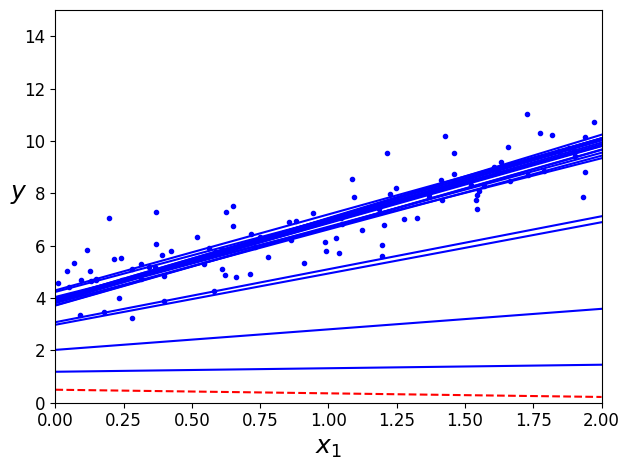

In [16]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):

        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        random_index = np.random.randint(m)

        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) #for SGD, do not divide by m

        eta = learning_schedule(epoch * m + i)

        theta = theta - eta * gradients

        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

Pour effectuer une régression linéaire en utilisant la descente de gradient stochastique (SGD) avec Scikit-Learn, vous pouvez utiliser la classe SGDRegressor, qui par défaut optimise la fonction de coût de l'erreur quadratique moyenne (MSE). Le code suivant s'exécute pour un maximum de 1 000 époques (max_iter) ou jusqu'à ce que la perte diminue de moins de 10−510−5 (tol) pendant 100 époques (n_iter_no_change). Il commence avec un taux d'apprentissage de 0.01 (eta0), en utilisant le planning d'apprentissage par défaut (différent de celui que nous avons utilisé).

In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

## Mini-batch gradient descent

Le dernier algorithme de descente de gradient que nous examinerons est appelé descente de gradient mini-batch. C'est simple une fois que vous connaissez la descente de gradient en batch et stochastique : à chaque étape, au lieu de calculer les gradients sur la base de l'ensemble d'entraînement complet (comme dans la descente de gradient en batch) ou sur la base d'une seule instance (comme dans la descente de gradient stochastique), la descente de gradient mini-batch calcule les gradients sur de petits ensembles aléatoires d'instances appelés mini-batches.

La progression de l'algorithme dans l'espace des paramètres est moins erratique qu'avec la descente de gradient stochastique, surtout avec des mini-batches assez grands. En conséquence, la descente de gradient mini-batch finira par se rapprocher un peu plus du minimum que la descente de gradient stochastique, mais il peut être plus difficile pour elle d'échapper aux minima locaux.



In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):

    shuffled_indices = np.random.permutation(m)

    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    for i in range(0, m, minibatch_size):
        t += 1

        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]

        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)

        eta = learning_schedule(t)

        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [21]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [22]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


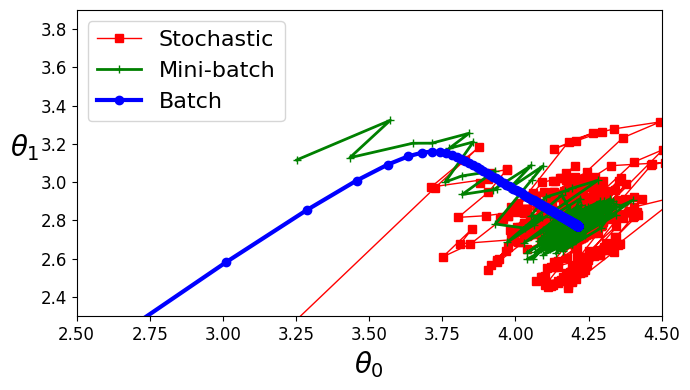

In [23]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial Regression

Que faire si vos données sont plus complexes qu'une simple ligne droite ? Étonnamment, vous pouvez utiliser un modèle linéaire pour ajuster des données non linéaires. Une manière simple de faire cela est d'ajouter des puissances de chaque caractéristique comme nouvelles caractéristiques, puis d'entraîner un modèle linéaire sur cet ensemble étendu de caractéristiques. Cette technique est appelée régression polynomiale.

In [24]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [25]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


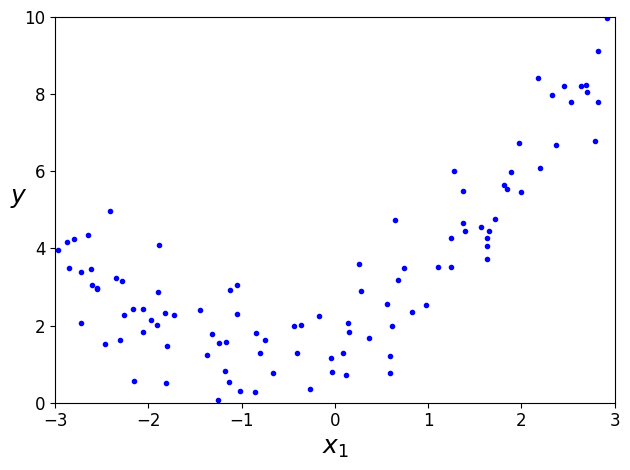

In [26]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Utilisons la classe `PolynomialFeatures` de Scikit-Learn pour transformer nos données d'entraînement, en ajoutant le carré (polynôme de degré deux) de chaque caractéristique de l'ensemble d'entraînement comme nouvelle caractéristique (dans ce cas, il n'y a qu'une seule caractéristique) :

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [28]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Le modèle estime $ y = 0.56x_1^2 + 0.93x_1 + 1.78 $ alors que la fonction originale était $ y = 0.5x_1^2 + 1.0x_1 + 2.0 $ avec du bruit gaussien.

Saving figure quadratic_predictions_plot


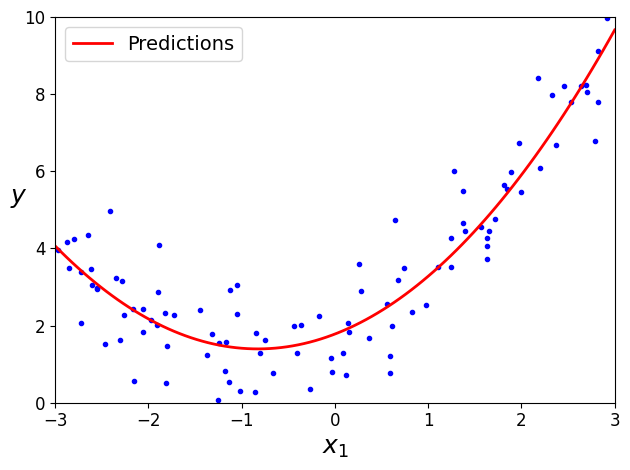

In [30]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Saving figure high_degree_polynomials_plot


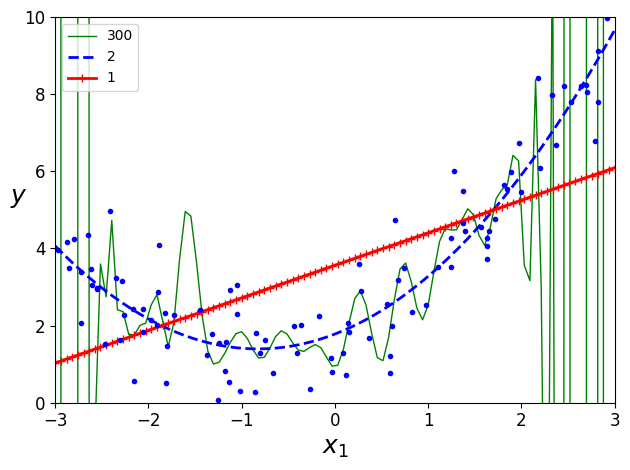

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

Si vous réalisez une régression polynomiale de degré élevé, vous ajusterez probablement les données d'entraînement beaucoup mieux qu'avec une simple régression linéaire. Par exemple, on applique un modèle polynomial de degré 300 aux données d'entraînement précédentes et compare le résultat avec un modèle linéaire pur et un modèle quadratique (polynôme de second degré). Remarquez comment le modèle polynomial de 300 degrés ondule pour se rapprocher autant que possible des instances d'entraînement.

Ce modèle de régression polynomiale de degré élevé surajuste sévèrement les données d'entraînement, tandis que le modèle linéaire les sous-ajuste.

Le modèle qui généralisera le mieux dans ce cas est le modèle quadratique, ce qui est logique car les données ont été générées à l'aide d'un modèle quadratique.

Mais en général, vous ne saurez pas quelle fonction a généré les données, alors comment pouvez-vous décider de la complexité que devrait avoir votre modèle ? Comment pouvez-vous dire que votre modèle surajuste ou sous-ajuste les données ?

# Learning Curves

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

    train_errors, val_errors = [], []

    for m in range(1, len(X_train) + 1):

        model.fit(X_train[:m], y_train[:m])

        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

Saving figure underfitting_learning_curves_plot


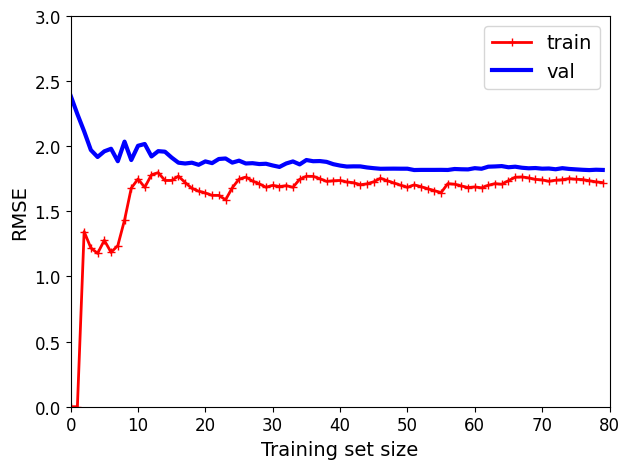

In [33]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

Ce modèle sous-ajuste les données. Pour comprendre pourquoi, examinons d'abord l'erreur d'entraînement. Lorsqu'il n'y a qu'une ou deux instances dans l'ensemble d'entraînement, le modèle peut les ajuster parfaitement, c'est pourquoi la courbe commence à zéro.

Cependant, à mesure que de nouvelles instances sont ajoutées à l'ensemble d'entraînement, il devient impossible pour le modèle d'ajuster parfaitement les données d'entraînement, à la fois parce que les données sont bruyantes et parce qu'elles ne sont pas du tout linéaires.

Ainsi, l'erreur sur les données d'entraînement augmente jusqu'à ce qu'elle atteigne un plateau, à partir duquel l'ajout de nouvelles instances à l'ensemble d'entraînement n'améliore ni n'aggrave beaucoup l'erreur moyenne.

Examinons maintenant l'erreur de validation. Lorsque le modèle est entraîné avec très peu d'instances d'entraînement, il est incapable de généraliser correctement, ce qui explique pourquoi l'erreur de validation est initialement assez grande.

Ensuite, à mesure que le modèle voit plus d'exemples d'entraînement, il apprend et, par conséquent, l'erreur de validation diminue lentement. Cependant, une fois de plus, une ligne droite ne peut pas bien modéliser les données, donc l'erreur atteint un plateau, très proche de l'autre courbe.

Saving figure learning_curves_plot


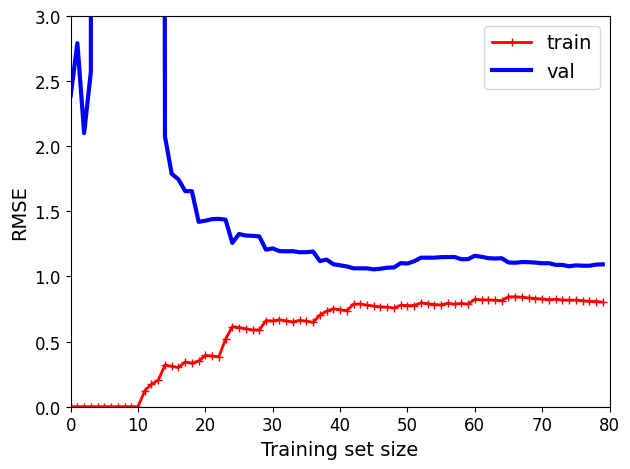

In [34]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

Ces courbes d'apprentissage ressemblent un peu aux précédentes, mais il y a deux différences très importantes :
- L'erreur sur les données d'entraînement est bien plus basse qu'auparavant.
- Il y a un écart entre les courbes. Cela signifie que le modèle fonctionne nettement mieux sur les données d'entraînement que sur les données de validation, ce qui est le signe caractéristique d'un modèle qui surajuste. Toutefois, si vous utilisiez un ensemble d'entraînement beaucoup plus grand, les deux courbes continueraient de se rapprocher.

Le compromis biais-variance est un résultat théorique important en statistiques et en apprentissage automatique. Il exprime que l'erreur de généralisation d'un modèle peut être décomposée en trois types d'erreurs très différentes :

**Biais** :
Cette partie de l'erreur de généralisation est due à des suppositions incorrectes, comme supposer que les données sont linéaires alors qu'elles sont en réalité quadratiques. Un modèle à fort biais a de fortes chances de sous-ajuster les données d'entraînement.

**Variance** :
Cette partie est due à la sensibilité excessive du modèle aux petites variations dans les données d'entraînement. Un modèle avec de nombreux degrés de liberté (comme un modèle polynomial de haut degré) est susceptible d'avoir une haute variance et donc de surajuster les données d'entraînement.

**Erreur irréductible** :
Cette partie est due au bruit inhérent aux données elles-mêmes. La seule manière de réduire cette partie de l'erreur est de nettoyer les données (par exemple, corriger les sources de données, comme des capteurs défectueux, ou détecter et retirer les valeurs aberrantes).

Augmenter la complexité d'un modèle augmentera typiquement sa variance et réduira son biais. Inversement, réduire la complexité d'un modèle augmente son biais et réduit sa variance. C'est pourquoi on parle de compromis.

# Regularized Linear Models

Une bonne manière de réduire le surajustement est de régulariser le modèle (c'est-à-dire de le contraindre) : moins il a de degrés de liberté, plus il lui sera difficile de surajuster les données. Une façon simple de régulariser un modèle polynomial est de réduire le nombre de degrés du polynôme.

Sans régularisation, notre modèle d'apprentissage automatique pourrait potentiellement trop bien apprendre les données d'entraînement et devenir excessivement sensible au bruit ou aux fluctuations dans les données historiques.

# Regularization Techniques for Linear Regression Models

## 1. Lasso Regression (Least Absolute Shrinkage and Selection Operator)
- **Regularization Technique**: L1 regularization.
- **Penalty Term**: Absolute value of the magnitude of the coefficients.
- **Purpose**: Minimizes the sum of the absolute values of the coefficients, effectively driving some coefficients to zero, which can be interpreted as a form of feature selection.
- **Cost Function**:
  $
  \text{Cost} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{i=1}^m |w_i|
  $
- **Application**: Useful when we suspect that some features might be irrelevant or when we need a sparse model.

## 2. Ridge Regression
- **Regularization Technique**: L2 regularization.
- **Penalty Term**: Squared magnitude of the coefficients.
- **Purpose**: Penalizes the sum of the squares of the coefficients, which helps in reducing the model complexity by shrinking the coefficients, though not necessarily to zero.
- **Cost Function**:
  $
  \text{Cost} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{i=1}^m w_i^2
  $
- **Application**: Effective when dealing with multicollinearity (correlated input features), providing stable estimates.

## 3. Elastic Net Regression
- **Regularization Technique**: Combination of L1 and L2 regularization.
- **Penalty Term**: Both absolute and squared magnitudes of the coefficients.
- **Purpose**: Combines the properties of both Lasso and Ridge. Controls the mix ratio between L1 and L2 regularization through an additional hyperparameter (α).
- **Cost Function**:
  $
  \text{Cost} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda ((1-\alpha) \sum_{i=1}^m |w_i| + \alpha \sum_{i=1}^m w_i^2)
  $
- **Application**: Particularly useful when there are multiple features correlated with each other. Elastic Net tends to group and shrink correlated features to a similar degree, hence maintaining a balance between feature selection and regularization.


## Ridge Regression

In [35]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [36]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [37]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

Saving figure ridge_regression_plot


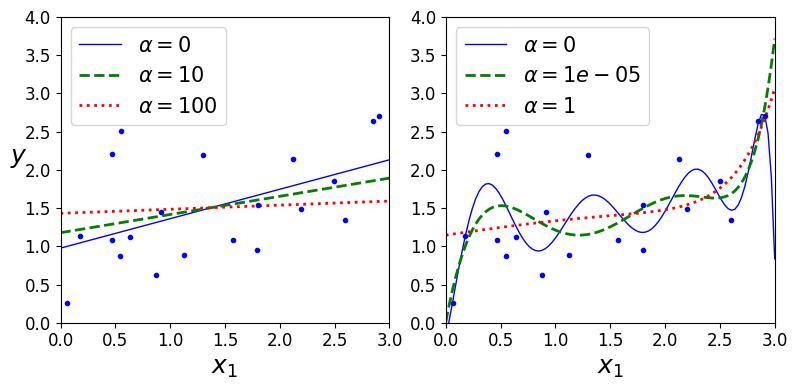

In [38]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

## Lasso Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


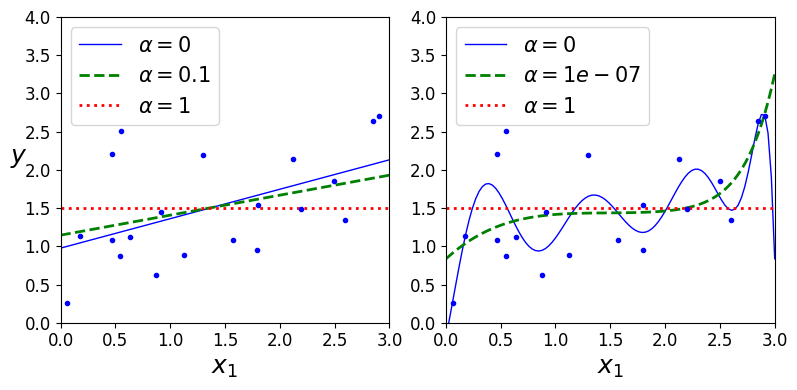

In [39]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [40]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net

In [41]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

Alors, quand devriez-vous utiliser la régression Elastic Net, ou Ridge, Lasso, ou encore la régression linéaire simple (c'est-à-dire sans aucune régularisation) ? Il est presque toujours préférable d'avoir au moins un peu de régularisation, donc en général, vous devriez éviter la régression linéaire simple. Ridge est un bon choix par défaut, mais si vous soupçonnez que seulement quelques caractéristiques sont utiles, vous devriez préférer Lasso ou Elastic Net car ces méthodes tendent à réduire à zéro les poids des caractéristiques inutiles, comme discuté précédemment. En général, Elastic Net est préféré à Lasso parce que Lasso peut se comporter de manière erratique lorsque le nombre de caractéristiques est supérieur au nombre d'instances d'entraînement ou lorsque plusieurs caractéristiques sont fortement corrélées.

## Early Stopping

 L'arrêt précoce est une technique de régularisation pour les algorithmes d'apprentissage itératif qui consiste à arrêter l'entraînement lorsque l'erreur de validation est la plus basse, empêchant ainsi le sur-ajustement des données d'entraînement. Cette méthode est reconnue pour sa simplicité et son efficacité.

In [42]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

Saving figure early_stopping_plot


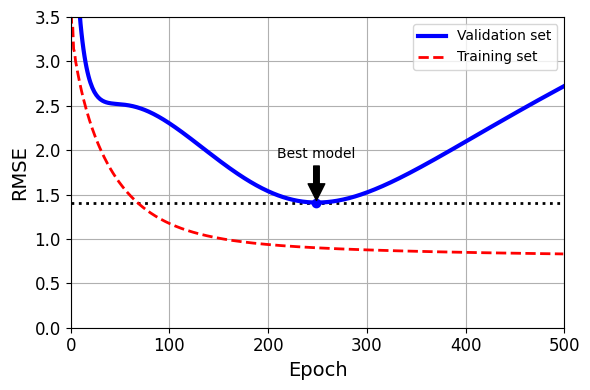

In [43]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()